<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import matplotlib.cm as cm
import os   
import keras as krs
import math
import h5py
import pickle
import getpass


from keras import utils as np_utils
from keras import backend as bknd

from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Input, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.datasets import cifar10, mnist
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, rmsprop
from keras.layers.core import Dense, Activation
from keras.regularizers import l1,l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler

from google.colab import files

Using TensorFlow backend.


In [0]:
from google.colab import drive
import pickle

drive.mount('/content/drive', force_remount=True)
DATA_PATH = "/content/drive/My Drive/Colab Tarea 3/Models/"

Mounted at /content/drive


In [0]:
def Repartir_Conjuntos(Train,Test,x,y):
  print("This function splits the framework this way:\n Train from 0% to (First parameter)%\n Test from (First parameter)% to (First+Second parameter)%\n Validation will be the rest.")
  if (0<Train<1) == False:
    print("ERROR: First parameter must be type float between 0 and 1")
    return
  if (0<Test<1) == False:
    print("ERROR: Second parameter must be type float between 0 and 1")
    return
  if (Train+Test<1) == False:
    print("ERROR: First parameter plus Second parameter can't be bigger than one")
    return
  
  largo = len(x);
  Train=int(Train*largo);
  Test = int(Test*largo + Train);
  (x_train, y_train)=x[0:Train],y[0:Train];
  (x_test, y_test)=x[Train:Test],y[Train:Test];
  (x_val, y_val)=x[Test:],y[Test:];
  return((x_train, y_train),(x_test, y_test),(x_val, y_val))

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train,x_test), axis=0);
x = x.astype('float32') / 255.
y = np.concatenate((y_train,y_test), axis=0);
[[x_train, y_train],[x_test, y_test],[x_val, y_val]]=Repartir_Conjuntos(0.5,0.3,x,y)

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_vals's shape:  ",y_val.shape)


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_val's shape:   ",y_val.shape)

11493376/11490434 [==============================] - 1s 0us/step
This function splits the framework this way:
 Train from 0% to (First parameter)%
 Test from (First parameter)% to (First+Second parameter)%
 Validation will be the rest.
-----------------------------------
x_train's shape:  (35000, 28, 28)
y_train's shape:  (35000,)
x_test's shape:   (21000, 28, 28)
y_test's shape:   (21000,)
x_val's shape:    (14000, 28, 28)
y_vals's shape:   (14000,)
-----------------------------------
x_train's shape:  (35000, 784)
y_train's shape:  (35000,)
x_test's shape:   (21000, 784)
y_test's shape:   (21000,)
x_val's shape:    (14000, 784)
y_val's shape:    (14000,)


<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

### 2.3 *Similarity reconstruct*

En esta sección se explorará una forma diferente de implementar un *autoencoder* que es utilizar la arquitectura del *autoencoder* pero no para reconstruir el mismo dato, sino que para reconstruir un dato similar. En este caso la similaridad estará dada por las clases de los datos.

> a) Genere pares de objetos $(objeto,similar)$ con 10 datos similares al dato "objeto", para ésto utilice la función que se provee a continuación sobre los primeros (1000 a 2000) datos de entrenamiento. **Visualice los nuevos datos generados y la relación que se produce entre los pares de objetos**.

In [0]:
def similarity_data(X,Y,sim=10):
    index_classes = [ np.where(Y==number)[0] for number in range(10)]
    new_X = np.zeros((1,X.shape[1]))
    simi_X = np.zeros((1,X.shape[1]))
    for x,y in zip(X,Y):
        similarities = index_classes[y]
        sample_sim = np.random.choice(similarities,sim)
        new_X = np.concatenate((new_X, np.tile(x,(sim,1))),axis=0)
        simi_X = np.concatenate((simi_X, X[sample_sim]),axis=0)
    return new_X[1:],simi_X[1:]
data, data_sim = similarity_data(x_train[:2000],y_train[:2000])


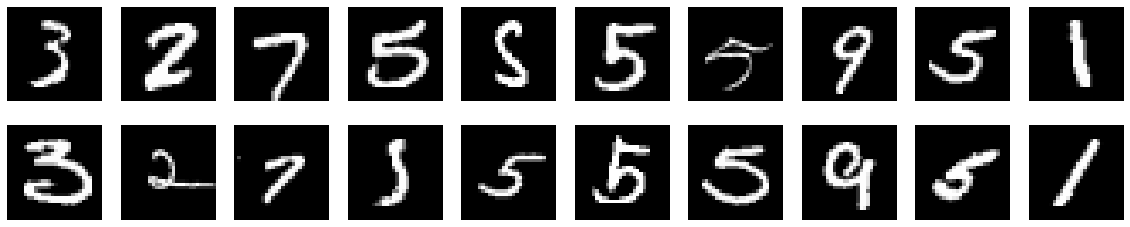

In [8]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(data))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(data_sim[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Se parean los objetos con una representación distinta de la misma categoría. En la figura se aprecia en la primera fila números escogidos aleatoreamente y en la segunda puede verse el número 'similar' autoseleccionado.


> b) Escoga algunas de las arquitecturas ya experimentadas hasta este punto de la actividad y entrénela para enfrentarla a éste problema **¿La función de pérdida se mantiene?**

In [9]:
mod=load_model(DATA_PATH+'T3_P2_1_relu_bc_d64.h5')
mod3 = mod.fit(data,data_sim,epochs=50,batch_size=32,validation_split=0.2)

Train on 16000 samples, validate on 4000 samples
Epoch 1/50
16000/16000 [==============================] - 3s 184us/step - loss: 0.3925 - val_loss: 0.3273
Epoch 2/50
16000/16000 [==============================] - 2s 139us/step - loss: 0.2934 - val_loss: 0.2811
Epoch 3/50
16000/16000 [==============================] - 2s 141us/step - loss: 0.2652 - val_loss: 0.2629
Epoch 4/50
16000/16000 [==============================] - 2s 143us/step - loss: 0.2527 - val_loss: 0.2546
Epoch 5/50
16000/16000 [==============================] - 2s 152us/step - loss: 0.2461 - val_loss: 0.2490
Epoch 6/50
16000/16000 [==============================] - 2s 146us/step - loss: 0.2420 - val_loss: 0.2460
Epoch 7/50
16000/16000 [==============================] - 2s 147us/step - loss: 0.2394 - val_loss: 0.2429
Epoch 8/50
16000/16000 [==============================] - 2s 146us/step - loss: 0.2375 - val_loss: 0.2414
Epoch 9/50
16000/16000 [==============================] - 2s 145us/step - loss: 0.2361 - val_loss: 0.24

> c) **Visualice lo que genera el *autoencoder* dado una imagen de entrada**. Además **visualice, con la herramienta TSNE, los *embedding*/representación reducida** que se producen en el *encoder*.

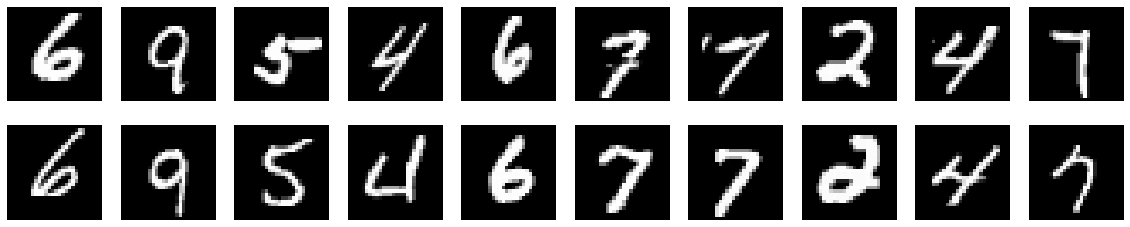

In [0]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(data))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(data[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(data_sim[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

-------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


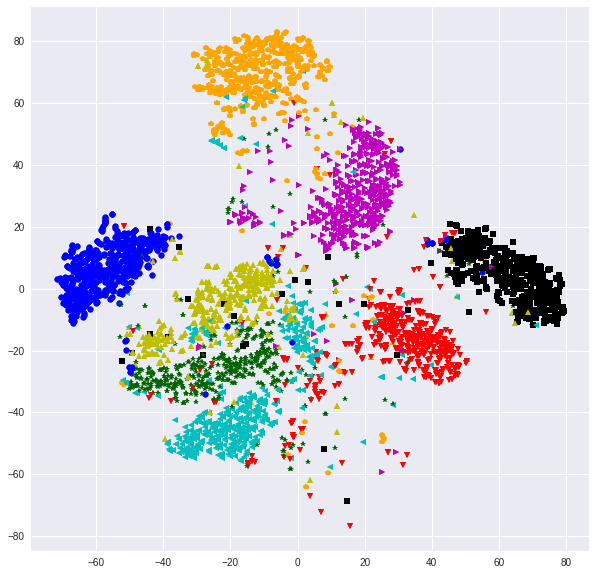

In [15]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

mods = [mod3]
prof =1
d=64

formato = 'Activation: {0}\nLoss: {1}\nd={2}\nDeepth: {3}'

for i in range(len(mods)):

  print('-------------------------------------------')
#   if modelos_deep[i][-2]=='d':
#     d=int(modelos_deep[i][-1])
#   else:
#     d=int(modelos_deep[i][-2:])
#   act = 'Sigmoid'
#   if 'relu' in modelos_deep[i]:
#     act = 'Relu'
#   losss = 'Mean Squared Error'
#   if '_bc_' in modelos_deep[i]:
#     losss = 'Binary Crossentropy'
#   prof = int(modelos_deep[i][19])
#   print(formato.format(act,losss,str(d),str(prof)))
  
  autoencoder = mod
  encoder = Model(input=autoencoder.input, output=autoencoder.layers[prof].output)

  autoencoder.predict(data)
  embeddings = encoder.predict(data) #project this with TSNE

  
  nplot=5000 #warning: mind your memory!

  encoded_train = encoder.predict(x_train[:nplot])
  from sklearn.manifold import TSNE

  model = TSNE(n_components=2, random_state=0)
  encoded_train = model.fit_transform(encoded_train)

  plt.figure(figsize=(10, 10))
  colors={0:'b',1:'g',2:'r',3:'c',4:'m',5:'y',6:'k',7:'orange',8:'darkgreen',9:'maroon'}
  markers={0:'o',1:'+',2: 'v',3:'<',4:'>',5:'^',6:'s',7:'p',8:'*',9:'x'}

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)
  pca = PCA(n_components=d)
  pca.fit(x_train)
  pca_train = pca.transform(x_train)
  pca_test = pca.transform(x_test)

  for idx in range(0,nplot):
      label = y_train[idx]
      line = plt.plot(encoded_train[idx][0], encoded_train[idx][1],
          color=colors[label], marker=markers[label], markersize=6)

Se aprecia nuevamente la agruación en los datos, con lo que se infiere que la red puede reconocer y separar los datos. Hay pequeñas intersecciones en el centro de la imagen, pero aún así el sistema logra separar las imágenes y clasificar.

<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.